# Introduction

This notebook contains the data cleaning and amalgamation for the final plot of the main body of my paper. 
The notebook also explores some other samples that we do not include, and includes brief descriptions of the methodology, limitations and attributes of each study.

# TODO pay attention to RL, CEL corrections and dwarf galaxy catagorizations

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import vice
from scipy.optimize import curve_fit
from astropy.io import fits
import json
import matplotlib as mpl

/astro/dboyea/.local/lib/python3.11/site-packages/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [2]:
from surp import ViceModel, yields, subgiants, DATA_DIR
from surp import gce_math as gcem

import surp
import arya
from arya import COLORS

In [3]:
surp.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   3.69e-03 MH^2 + 1.96e-03 MH +  1.45 × cristallo11             0.00e+00                       
                    2.20e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





In [3]:
import sys; sys.path.append("..")

In [4]:
from singlezone import run_singlezone, exp_sfh

In [5]:
def to_nice(apogee_name):
    return "[" + apogee_name.title().replace("_", "/") + "]"

In [6]:
def plot_abund_errs(df, x="O_H", y="C_O", **kwargs):
    xs = df[x].values
    ys =  df[y].values
    xerr = df[f"{x}_err"].values
    yerr = df[f"{y}_err"].values
    filt = ~np.isnan(xerr) 
    filt &= ~np.isnan(yerr)
    filt &= xerr > 0
    filt &= yerr > 0
    
    plt.errorbar(xs[filt], ys[filt], xerr=xerr[filt], yerr=yerr[filt], fmt="o", capsize=0, **kwargs)
    plt.xlabel(to_nice(x))
    plt.ylabel(to_nice(y))

In [7]:
def plot_sample(df, **kwargs):    
    plot_abund_errs(df, x="FE_H", y="O_FE", **kwargs)
    plt.show()
    
    plot_abund_errs(df, **kwargs)
    plt.show()
    
    plot_abund_errs(df, x="O_FE", **kwargs)
    plt.show()
    
    if "MG_FE" in df.columns:
        plot_abund_errs(df, x="O_H", y="O_MG", **kwargs)
        plot_abund_errs(df, x="MG_H", y="C_MG", **kwargs)
        plot_abund_errs(df, x="MG_FE", y="C_MG", **kwargs)
        plt.show()
                    

In [8]:
def calc_errs(df, idx=None):
    series = pd.Series()
    series["O_H_err"] = np.nanmean(df["O_H_err"])
    series["C_O_err"] = np.nanmean(df["C_O_err"])
    
    if idx is None:
        O_H = np.mean(df.O_H)
        C_O = np.mean(df.C_O)
        
        idx = np.argmin((df.O_H - O_H)**2 )#+ (df.C_O - C_O)**2)
        series["O_H"] = df.O_H.iloc[idx]
        series["C_O"] = df.C_O.iloc[idx]
    
    return series.to_frame().T

In [9]:
def plot_sample_err(df, df_err, color=COLORS[0], marker="*", label="", **kwargs):
    plt.scatter(df["O_H"], df["C_O"], marker=marker, color=color, label=label, **kwargs)
    

    plt.errorbar(df_err["O_H"], df_err["C_O"],  xerr=df_err.O_H_err, yerr=df_err.C_O_err,
             marker="none", ls="none", color=color, capsize=0, **kwargs)
    
    plt.xlabel("[O/H]")
    plt.ylabel("[C/O]")

In [11]:
surp.set_yields(verbose=False)
c_o_correction = np.log10(12.01/15.99) - np.log10(vice.solar_z("c") / vice.solar_z("o"))
eps_o_correction =  - 12 + np.log10(15.99) - np.log10(vice.solar_z("o"))

# Stars
Samples of MW stars.
See also `catalogues` and `clean_surveys` notebooks.

## Amarsi et al. (2019)
3D NLTE corrected sample

Builds on: 
- Nissen et al. (2014)
- Amarsi et al. (2019a) which therein builds on  Nissen et al. (2007). which contains most of what Fabbian et al. (2009) presents.

In [14]:
amarsi19 = pd.read_csv(surp.DATA_DIR + "amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)

amarsi19["FE_H"] = amarsi19["[Fe/H]3L"]
amarsi19["FE_H_err"] = amarsi19["e_[Fe/H]3L"]

amarsi19["O_H"] = amarsi19["[O/H]3N"]
amarsi19["O_H_err"] = amarsi19["e_[O/H]3N"]

amarsi19["C_H"] = amarsi19["[C/H]3N"]
amarsi19["C_H_err"] = amarsi19["e_[C/H]3N"]

amarsi19["C_O"] = amarsi19["C_H"] - amarsi19["O_H"] 
amarsi19["C_O_err"] = amarsi19["O_H_err"] + amarsi19["C_H_err"] 

amarsi19["O_FE"] = amarsi19["O_H"] - amarsi19["[Fe/H]3L"]
amarsi19["O_FE_err"] = amarsi19["e_[Fe/H]3L"] + amarsi19["O_H_err"]

amarsi19_sun = amarsi19.iloc[151]
amarsi19.drop(index=151, inplace=True)

/tmp/ipykernel_3862843/3749996996.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  amarsi19 = pd.read_csv(surp.DATA_DIR + "amarsi_19.tsv", delimiter="\t *", comment="#", skiprows=[62, 63],)


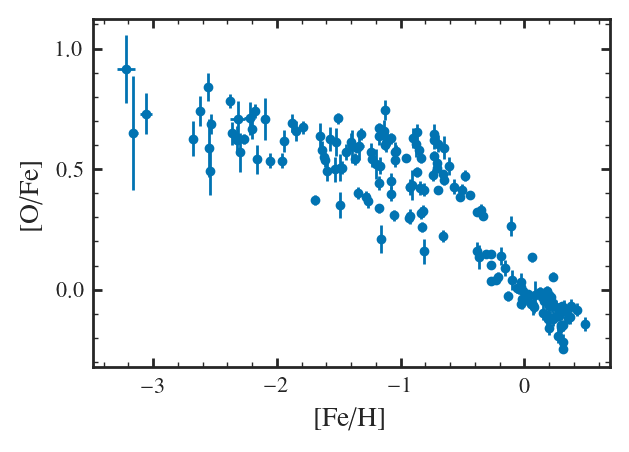

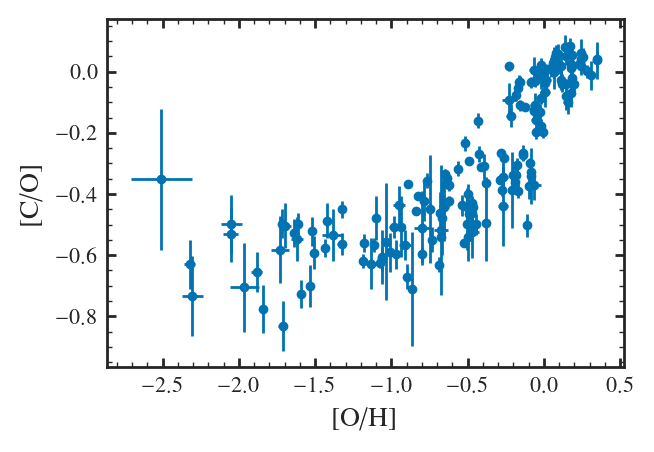

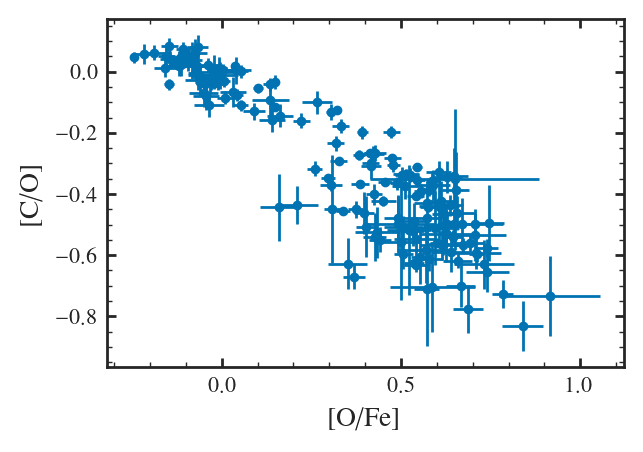

In [15]:
plot_sample(amarsi19)

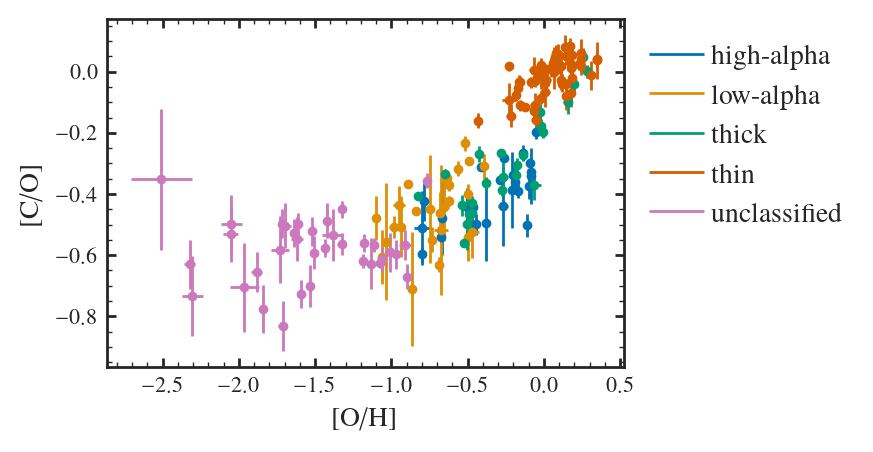

In [16]:
for pop in amarsi19.Pop.unique():
    filt = amarsi19.Pop == pop
    plot_abund_errs(amarsi19[filt], label=pop)

arya.Legend(-1)


Text(0, 0.5, 'C_O')

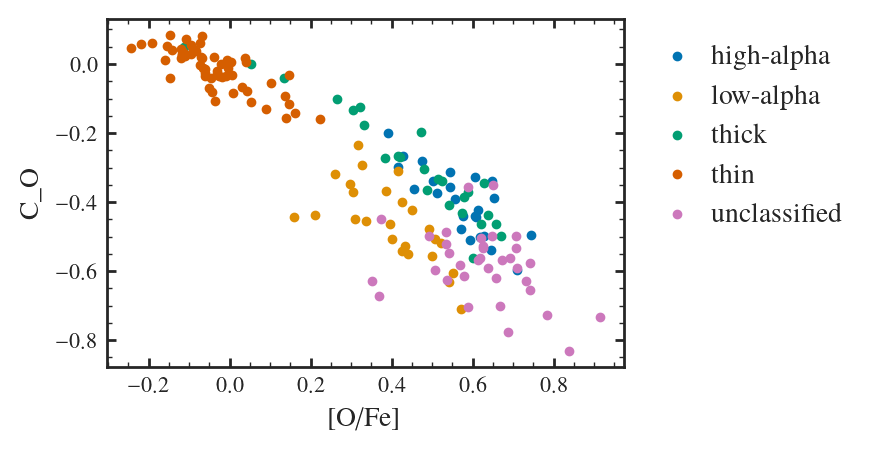

In [17]:
for pop in amarsi19.Pop.unique():
    filt = amarsi19.Pop == pop
    plt.scatter(amarsi19[filt].O_FE, amarsi19[filt]["C_O"], label=pop)

arya.Legend(-1)
plt.xlabel("[O/Fe]")
plt.ylabel("C_O")

### NLTE vs LTE

while e.g. Fe is stable, C requires up to -0.2 dex corrections at low metallicities.

Text(0, 0.5, '3D LTE - 1D LTE')

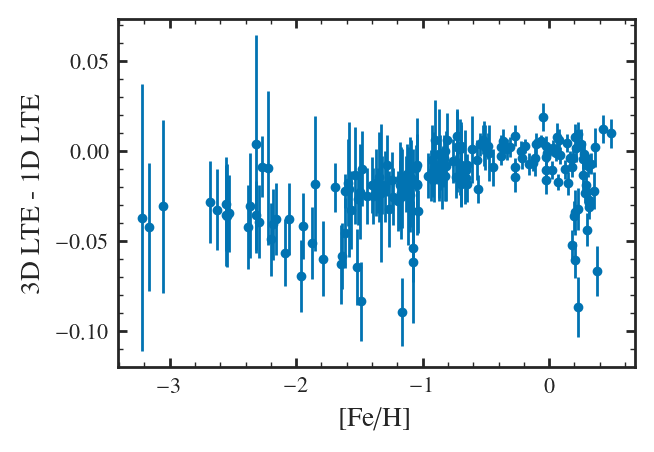

In [18]:
plt.errorbar(amarsi19.FE_H, amarsi19["[Fe/H]1L"] - amarsi19["[Fe/H]3L"], yerr=amarsi19["e_[Fe/H]3L"], fmt="o", capsize=0)
plt.xlabel("[Fe/H]")
plt.ylabel("3D LTE - 1D LTE")

Text(0, 0.5, '1D LTE - 3D NLTE')

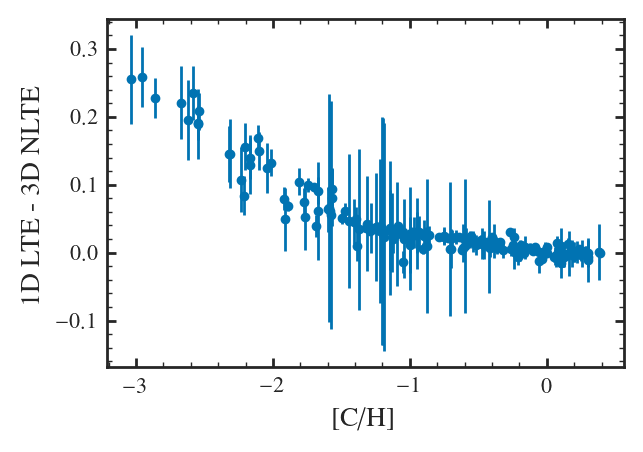

In [19]:
plt.errorbar(amarsi19.C_H, amarsi19["[C/H]1L"] - amarsi19["[C/H]3N"], yerr=amarsi19["e_[C/H]3N"], fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel("1D LTE - 3D NLTE")

Text(0, 0.5, '1D LTE - 3D NLTE')

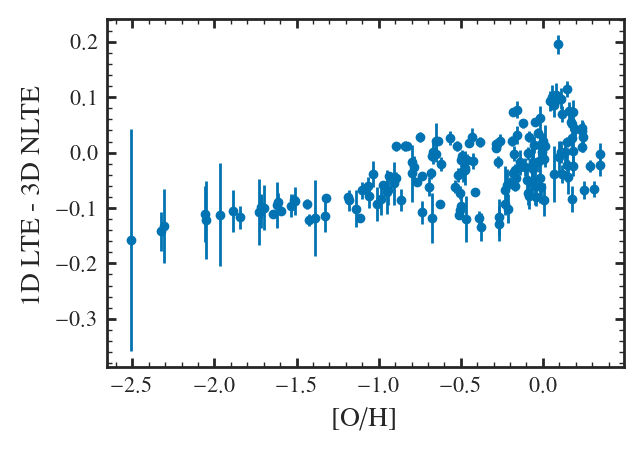

In [20]:
plt.errorbar(amarsi19.O_H, amarsi19["[O/H]1L"] - amarsi19["[O/H]3N"], yerr=amarsi19["e_[O/H]3N"], fmt="o", capsize=0)
plt.xlabel("[O/H]")
plt.ylabel("1D LTE - 3D NLTE")

In [22]:
amarsi19.to_csv("amarsi19_cleaned.csv")

## Zhao et al. 2016
https://ui.adsabs.harvard.edu/abs/2016ApJ...833..225Z/abstract


NLTE 1D abundances. MW thin, thick, and halo stars.
- 51 nearby stars -
- lick on 3m with R~60k from 3700-9300Å, S/N > 100 for most.
- about 10 C lines, most are around 9000Å.
- NonLTE - LTE for C is ~0 at 5052Å, but are  ~ -0.1dex  at 9111Å. not correlated with Fe.
- Also includes CH and C2 bands


In [23]:
z16_long = pd.read_csv(DATA_DIR + "zhao+2016.tsv", delimiter="\t[ ]*", comment="#")

/tmp/ipykernel_3862843/2455137159.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  z16_long = pd.read_csv(DATA_DIR + "zhao+2016.tsv", delimiter="\t[ ]*", comment="#")


In [24]:
z16_long

,Name,Teff,logg,[Fe/H],xi,Pop,Z,Species,N,[X/H]LTE,e_[X/H]LTE,[X/Fe]LTE,[X/H]NLTE,e_[X/H]NLTE,[X/Fe]NLTE
0,HD 19373,6045,4.24,0.10,1.2,Thin disk,3.0,Li I,1,2.50,NaN,NaN,2.47,NaN,NaN
1,HD 19373,6045,4.24,0.10,1.2,Thin disk,6.0,C I,5,0.00,0.04,-0.10,-0.05,0.05,-0.15
2,HD 19373,6045,4.24,0.10,1.2,Thin disk,NaN,CH,13,0.10,0.06,0.00,NaN,NaN,NaN
3,HD 19373,6045,4.24,0.10,1.2,Thin disk,8.0,O I,4,0.01,0.01,-0.09,-0.06,0.04,-0.16
4,HD 19373,6045,4.24,0.10,1.2,Thin disk,11.0,Na I,4,0.27,0.06,0.17,0.21,0.04,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,G090-003,6007,3.90,-2.04,1.3,Halo,29.0,Cu I,0,NaN,NaN,NaN,NaN,NaN,NaN
1016,G090-003,6007,3.90,-2.04,1.3,Halo,38.0,Sr II,2,-1.98,0.01,0.06,-2.13,0.00,-0.09
1017,G090-003,6007,3.90,-2.04,1.3,Halo,40.0,Zr II,2,-1.67,0.05,0.37,-1.65,0.04,0.39
1018,G090-003,6007,3.90,-2.04,1.3,Halo,56.0,Ba II,4,-2.12,0.07,-0.08,-2.00,0.05,0.04


In [25]:
z16 = z16_long.pivot_table(index='Name', columns='Species', 
    values=['[X/H]LTE', 'e_[X/H]LTE', '[X/Fe]LTE', '[X/H]NLTE', 'e_[X/H]NLTE','[X/Fe]NLTE'], aggfunc='first')


In [26]:
z16.columns = [a.replace("X", b.strip()).replace("NLTE", "") for a, b in z16.columns.values]

In [27]:
z16 = pd.merge(z16_long[["Name", "Teff", "logg", "[Fe/H]", "xi"]].drop_duplicates(), z16, on='Name')

In [28]:
z16.columns.values

array(['Name', 'Teff', 'logg', '[Fe/H]', 'xi', '[Al I/Fe]LTE',
       '[Ba II/Fe]LTE', '[C I/Fe]LTE', '[CH/Fe]LTE', '[Ca I/Fe]LTE',
       '[Cu I/Fe]LTE', '[Eu II/Fe]LTE', '[Fe I/Fe]LTE', '[Fe II/Fe]LTE',
       '[K I/Fe]LTE', '[Mg I/Fe]LTE', '[Na I/Fe]LTE', '[O I/Fe]LTE',
       '[Sc II/Fe]LTE', '[Si I/Fe]LTE', '[Si II/Fe]LTE', '[Sr II/Fe]LTE',
       '[Ti II/Fe]LTE', '[Zr II/Fe]LTE', '[Al I/Fe]', '[Ba II/Fe]',
       '[C I/Fe]', '[Ca I/Fe]', '[Cu I/Fe]', '[Eu II/Fe]', '[Fe I/Fe]',
       '[Fe II/Fe]', '[K I/Fe]', '[Mg I/Fe]', '[Na I/Fe]', '[O I/Fe]',
       '[Sc II/Fe]', '[Si I/Fe]', '[Si II/Fe]', '[Sr II/Fe]',
       '[Ti II/Fe]', '[Zr II/Fe]', '[Al I/H]LTE', '[Ba II/H]LTE',
       '[C I/H]LTE', '[CH/H]LTE', '[Ca I/H]LTE', '[Cu I/H]LTE',
       '[Eu II/H]LTE', '[Fe I/H]LTE', '[Fe II/H]LTE', '[K I/H]LTE',
       '[Li I/H]LTE', '[Mg I/H]LTE', '[Na I/H]LTE', '[O I/H]LTE',
       '[Sc II/H]LTE', '[Si I/H]LTE', '[Si II/H]LTE', '[Sr II/H]LTE',
       '[Ti II/H]LTE', '[Zr II/H]LTE', '[Al I

Text(0, 0.5, 'logg')

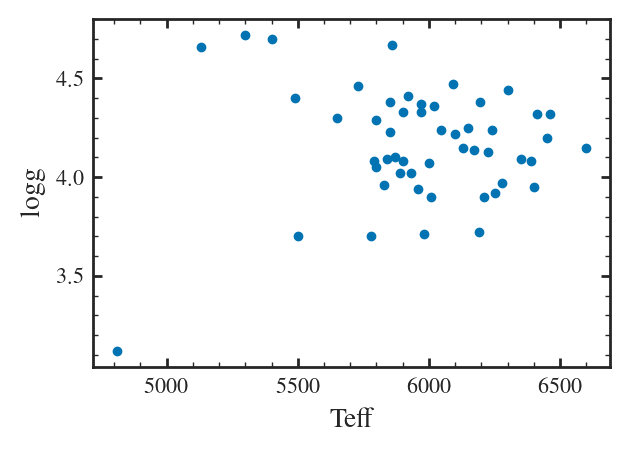

In [29]:
plt.scatter(z16.Teff, z16.logg)
plt.xlabel("Teff")
plt.ylabel("logg")

In [30]:
z16["C_H"] = z16["[C I/H]"] 
z16["C_H_err"] = z16["e_[C I/H]"] 


z16["C_O"] = z16["[C I/H]"] - z16["[O I/H]"]
z16["C_O_err"] = z16["e_[C I/H]"] - z16["e_[O I/H]"]

z16["O_H"] = z16["[O I/H]"]
z16["O_H_err"] = z16["e_[O I/H]"]

z16["FE_H"] = z16["[Fe I/H]"]
z16["FE_H_err"] = z16["e_[Fe I/H]"]

z16["O_FE"] = z16["[O I/Fe]"]
z16["O_FE_err"] = z16["e_[O I/H]"] + z16["e_[Fe I/H]"]

Text(0, 0.5, '1D LTE - 3D NLTE')

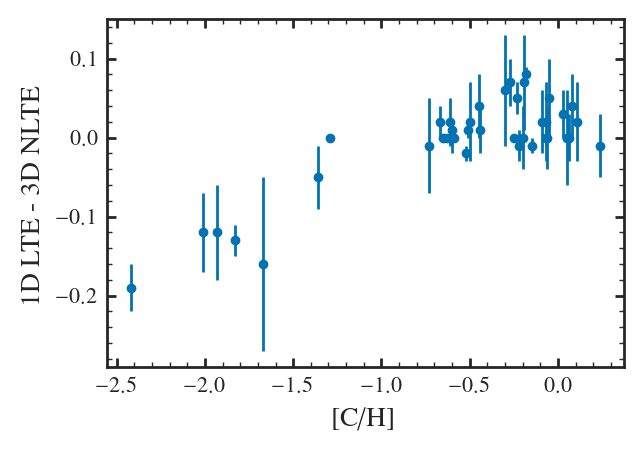

In [31]:
plt.errorbar(z16.C_H, z16["[C I/H]LTE"] - z16.C_H, yerr=z16.C_H_err, fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel("1D LTE - 3D NLTE")

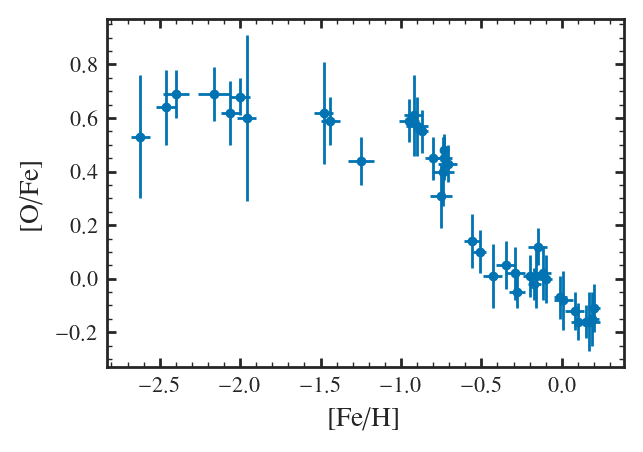

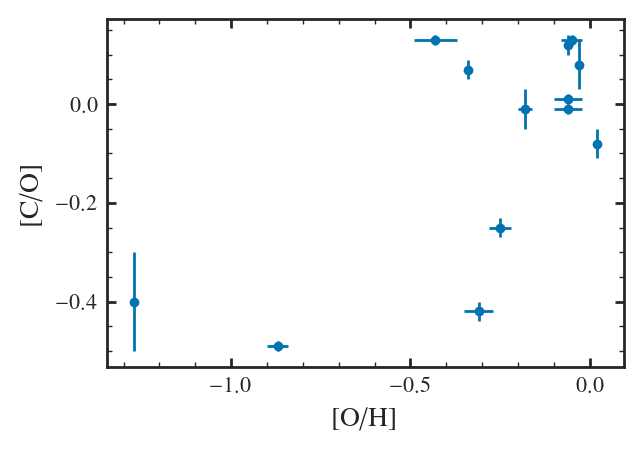

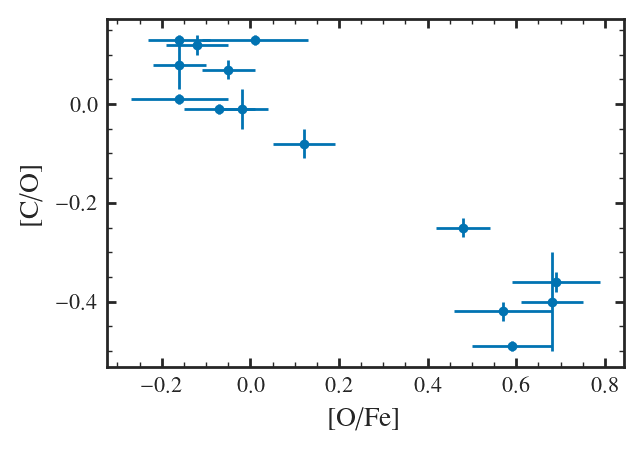

In [32]:
plot_sample(z16)

Text(0, 0.5, ' LTE - NLTE')

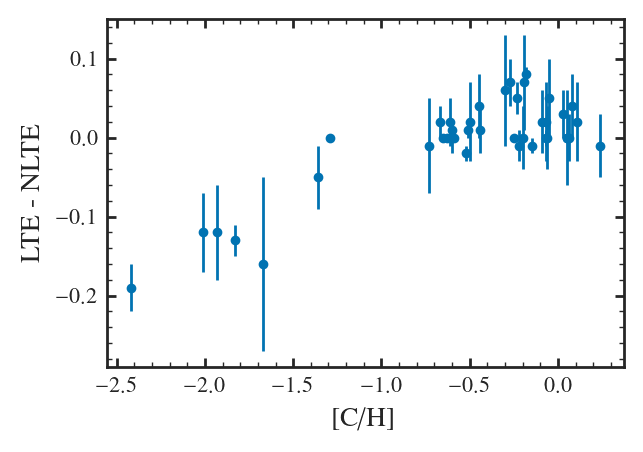

In [119]:
plt.errorbar(z16.C_H, z16["[C I/H]LTE"] - z16.C_H, yerr=z16.C_H_err, fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel(" LTE - NLTE")

Text(0, 0.5, 'CH - C I')

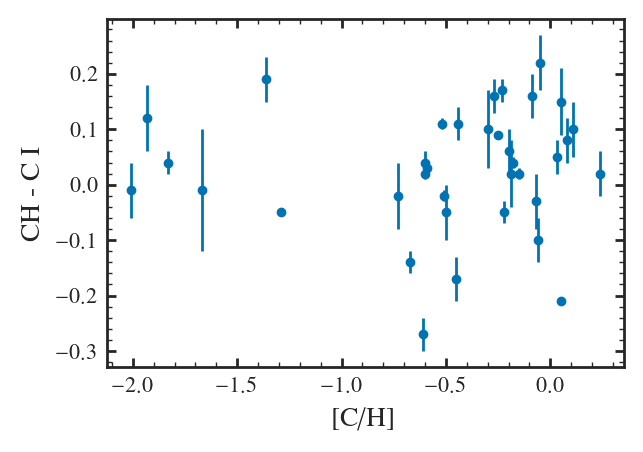

In [34]:
plt.errorbar(z16.C_H, z16["[CH/Fe]LTE"] - z16.C_H + z16.FE_H, yerr=z16.C_H_err, fmt="o", capsize=0)
plt.xlabel("[C/H]")
plt.ylabel("CH - C I")

Text(0, 0.5, '1D LTE - 3D NLTE')

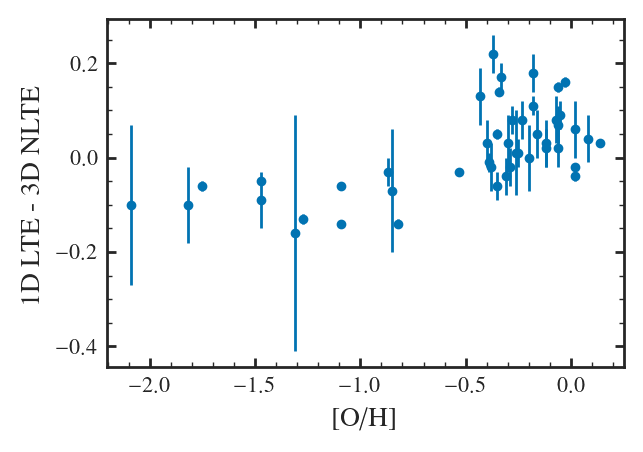

In [117]:
plt.errorbar(z16.O_H, z16["[O I/H]LTE"] - z16.O_H, yerr=z16.O_H_err, fmt="o", capsize=0)
plt.xlabel("[O/H]")
plt.ylabel("1D LTE - 3D NLTE")

In [37]:
z16.to_csv("zhao+16_cleaned.csv")

## Combined

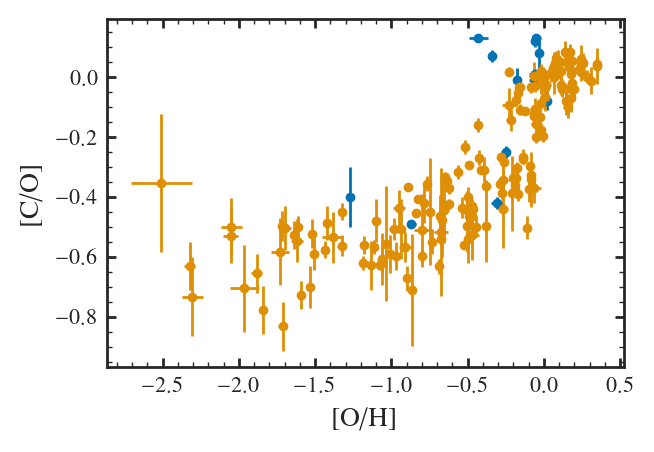

In [124]:
plot_abund_errs(z16)
plot_abund_errs(amarsi19)

## Extra

### bedell 18
solar twins sample. https://ui.adsabs.harvard.edu/abs/2018ApJ...865...68B/abstract.
Doesn't help with global trends since all stars almost same


In [36]:
b18 = pd.read_csv(DATA_DIR + "bedell18.dat", delimiter=" +", comment="#")

/tmp/ipykernel_3862843/51954004.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  b18 = pd.read_csv(DATA_DIR + "bedell18.dat", delimiter=" +", comment="#")


Text(0, 0.5, '[C/O]')

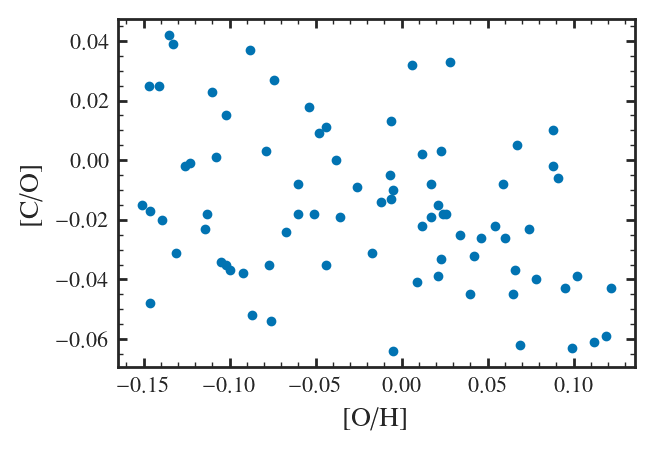

In [18]:
plt.scatter(b18["[OI/H]"], b18["[CI/H]"] - b18["[OI/H]"])
plt.xlabel("[O/H]")
plt.ylabel("[C/O]")

### Bensby et al. (2019, 2021)
The galactic bulge sample

In [38]:
bensby21 = pd.read_csv(DATA_DIR + "bensby21.tsv", delimiter="\t *", comment="#",engine='python')
bensby19 = pd.read_csv(DATA_DIR + "bensby19.tsv", delimiter="\t *", comment="#",engine='python')

bensby = bensby21.set_index("Name").join(bensby19.set_index("Name"),rsuffix="_b19", how="left")

bensby["C_O"] = bensby["[C/H]"] - bensby["[O/H]"]
bensby["C_O_err"] = bensby["e_[C/O]"]

bensby["O_FE"] = bensby["[O/H]"] - bensby["[Fe/H]"]
bensby["O_FE_err"] = bensby["e_[O/H]"] + bensby["e_[Fe/H]"]

bensby["O_H"] = bensby["[O/H]"]
bensby["O_H_err"] = bensby["e_[O/H]"]

bensby["FE_H"] = bensby["[Fe/H]"]
bensby["FE_H_err"] = bensby["e_[Fe/H]"]


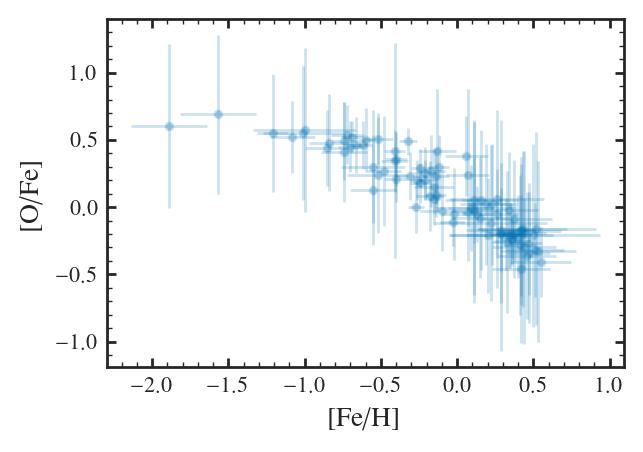

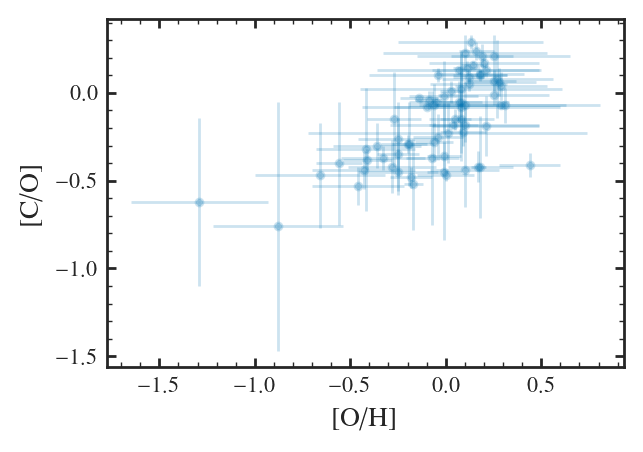

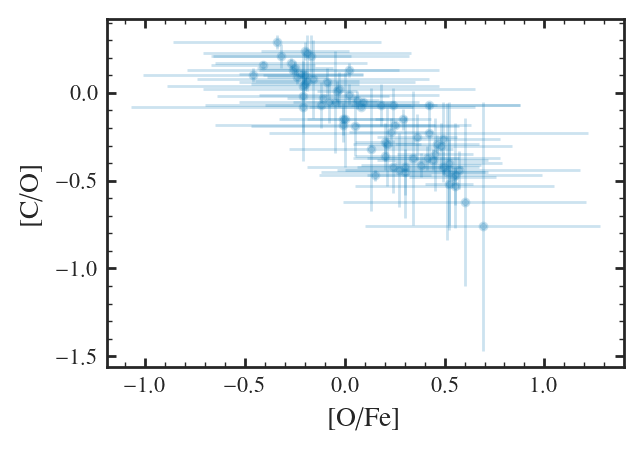

In [39]:
plot_sample(bensby, alpha=0.2)

### Fabbian et al. 2009
Rehashed in Amarsi

In [34]:
F09 = pd.read_csv(DATA_DIR + "Fabbian09.csv", sep="\s+")

# RL

work from
- Esteban et al . (2002, 2009, 2014)
- García-Rojas et al. (2007)
- López-Sánchez et al. (2007)
- Mendez-Delgado et al. 2022
- Skillman et al. (2020)
- Toribio San Cipriano et al. 2016, 2017.
- Peimbert et al. 2005


Other
- Peimberg 2003 does 30 Dor in LMC (like TSC)
- García-Rojas 2003, 2004, 2006 (galactic regions)
- Tsamis et al. 2003. (galactic and LMC, covered by more modern studies)



Included

Feldmeier-Krause; Lonoce, I., Freedman, W. L. https://ui.adsabs.harvard.edu/abs/2021ApJ...923...65F/abstract

## Skillman et al. 2020
M101 data from CHAOS

In [40]:
def read_skillman20():
    df = pd.read_csv(DATA_DIR + "chaos_m101.dat", sep="\s+")
    df1 = pd.DataFrame()
    df1["O_H"] = gcem.eps_to_brak(df["O_H"], "o")
    df1["C_O"] = gcem.log_to_brak(df["C_O"], "c", "o")
    df1["[c/n]"] = gcem.log_to_brak(df["C_N"], "c", "n")
    df1["[n/o]"] = df1["C_O"] - df1["[c/n]"]

    df1["O_H_err"] = df["O_H_err"]
    df1["C_O_err"] = df["C_O_err"] 
    df1["[c/n]_err"] = df["C_N_err"] * 12/14
    df1["[n/o]_err"] = df["C_O_err"] + df["C_N_err"]

    df1.name="M101"
    return df1

skillman20 = read_skillman20()

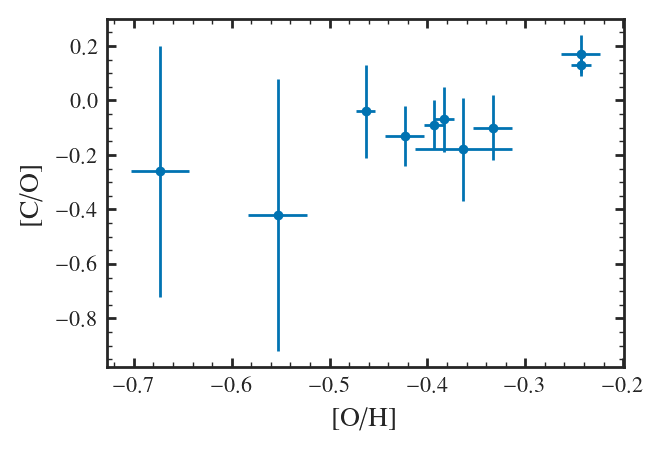

In [41]:
plot_abund_errs(skillman20)

##  Toribio San Cipriano et al. (2016)
NGC 300 and M33 abundances using RL on UVES

In [42]:
tsc16 = pd.read_csv(f"{DATA_DIR}/TSC16.tsv", sep=r"\s+", comment="#")

In [43]:
tsc16["O_H"] = gcem.eps_to_brak(tsc16.eps_o, "o")
tsc16["O_H_err"] = tsc16.eps_o_err
tsc16["C_O"] = gcem.log_to_brak(tsc16.log_c_o, "c", "o")
tsc16["C_O_err"] = tsc16.log_c_o_err

In [44]:
tsc16

,galaxy,object,eps_o,eps_o_err,log_c_o,log_c_o_err,O_H,O_H_err,C_O,C_O_err
0,NGC300,R20,8.69,0.11,-0.22,0.22,-0.123177,0.11,-0.00963,0.22
1,NGC300,R23,8.70,0.13,-0.43,0.23,-0.113177,0.13,-0.21963,0.23
2,NGC300,R14,8.62,0.11,-0.36,0.21,-0.193177,0.11,-0.14963,0.21
3,NGC300,R2,8.57,0.12,-0.52,0.22,-0.243177,0.12,-0.30963,0.22
4,M33,NGC588,8.49,0.09,-0.47,0.19,-0.323177,0.09,-0.25963,0.19
5,M33,IC132,8.47,0.12,-0.33,0.15,-0.343177,0.12,-0.11963,0.15


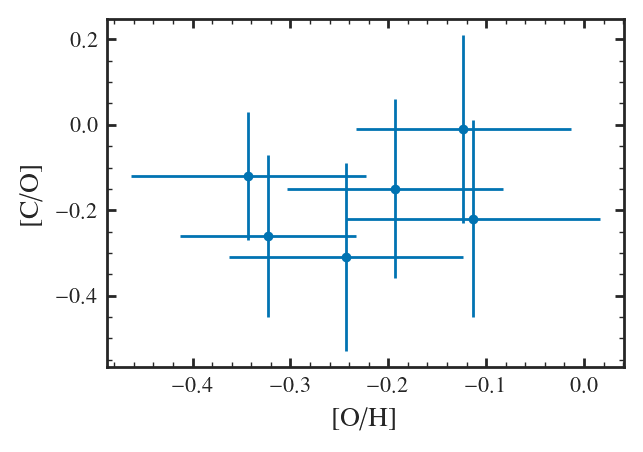

In [45]:
plot_abund_errs(tsc16)

##  Toribio San Cipriano et al. (2017)
LMC and SMC abundances using RL, 5 and 4 HII regions respectively.
Compares to CEL lines
- C II 4267.15
- ~ 7 \[O II\] lines

In [46]:
tsc17 = pd.read_csv(f"{DATA_DIR}/TSC17.tsv", sep=r"\s+", comment="#")

In [47]:
tsc17["O_H"] = gcem.eps_to_brak(tsc17.eps_o, "o")
tsc17["O_H_err"] = tsc17.eps_o_err
tsc17["C_O"] = gcem.log_to_brak(tsc17.log_c_o, "c", "o")
tsc17["C_O_err"] = tsc17.log_c_o_err

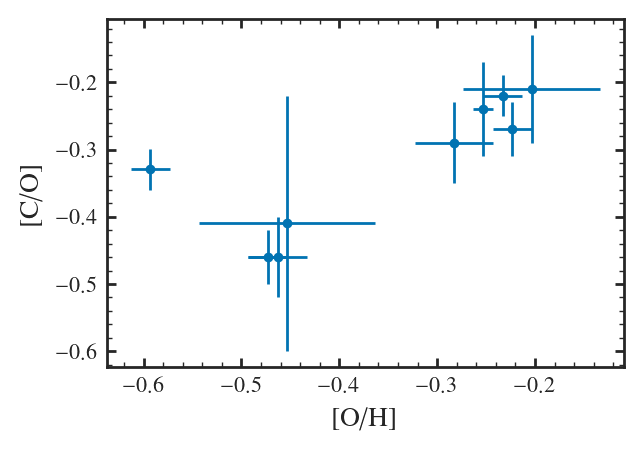

In [48]:
plot_abund_errs(tsc17)

## Mendez-Delgado et al. 2022
MW HII regions

In [49]:
def read_md22():
    df = pd.read_csv(DATA_DIR + "md22.csv")
    df1 = pd.DataFrame()
    df1["O_H"] = gcem.eps_to_brak(df["O_H"], "o")
    df1["[c/h]"] = gcem.eps_to_brak(df["C_H"], "c")
    df1["[n/h]"] = gcem.eps_to_brak(df["N_H"], "n")

    df1["[c/n]"] = df1["[c/h]"] - df1["[n/h]"]
    df1["C_O"] = df1["[c/h]"] - df1["O_H"]
    df1["[n/o]"] = df1["[n/h]"] - df1["O_H"]

    df1["O_H_err"] = df["O_H_err"]
    df1["C_O_err"] = df["C_H_err"] + df["O_H_err"]
    df1["[n/o]_err"] = df["N_H_err"] + df["O_H_err"]
    df1["[c/n]_err"] = df["C_H_err"] + df["N_H_err"]

    df1.name = "Milkyway"
    return df1
md22 = read_md22()
md22a = pd.read_csv(DATA_DIR + "md22.csv")


Text(0, 0.5, 'eps C')

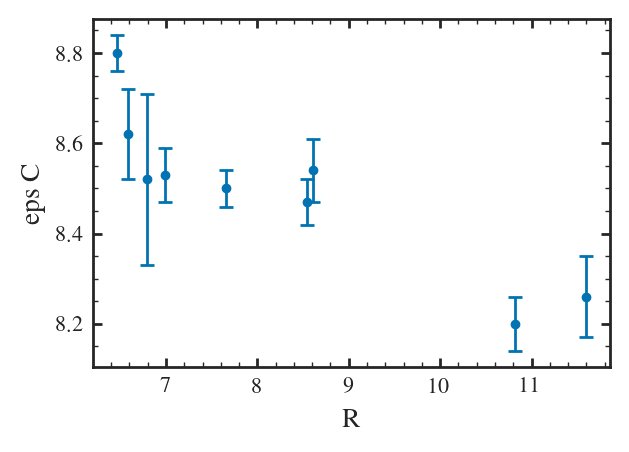

In [50]:
plt.errorbar(md22a.R_g, md22a.C_H, yerr=md22a.C_H_err, fmt="o")
plt.xlabel("R")
plt.ylabel("eps C")

Text(0, 0.5, 'eps(O)')

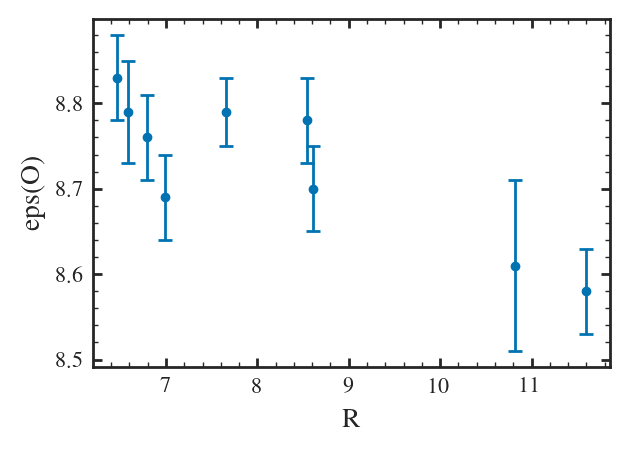

In [51]:
plt.errorbar(md22a.R_g, md22a.O_H, yerr=md22a.O_H_err, fmt="o")
plt.xlabel("R")
plt.ylabel("eps(O)")

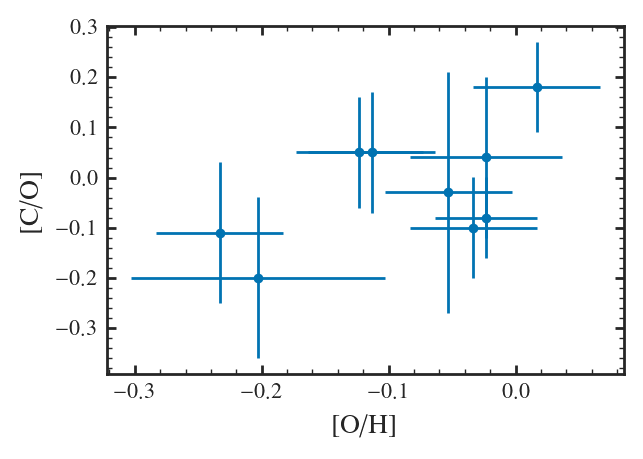

In [52]:
plot_abund_errs(md22)

## Misc

### Peimbert & Peimbert 2005
NGC 6822 (dwarf Irr) on VLT, RLs

- CII 4267
- CII 6151
- CII 6734

4 OII lines

### E02

### LS 07
NGC 5253



In [53]:
RL = pd.read_csv(DATA_DIR + "extragalactic_RL.csv", sep="\s+")
RL["C_O"] = gcem.log_to_brak(RL.eps_c - RL.eps_o, "c", "o")
RL["O_H"] = gcem.eps_to_brak(RL.eps_o, "o")
RL["C_O_err"] = np.sqrt(RL.c_err**2 + RL.o_err**2)
RL["O_H_err"] = RL.o_err 

In [54]:
RL.drop(np.where(np.isin(RL["object"], ["VS-24", "VS-38", "NGC-5447", "30-Dor",
                                       "M8", "M17"]))[0], inplace=True)


In [55]:
RL

,source,galaxy,class,object,eps_c,c_err,eps_n,n_err,eps_o,o_err,eps_fe,fe_err,C_O,O_H,C_O_err,O_H_err
0,E02,NGC-5471,?,?,7.79,NaN,6.51,0.15,8.23,0.05,6.36,0.09,-0.22963,-0.583177,NaN,0.05
1,E09,M31,S,K932,8.46,0.13,7.63,0.06,8.62,0.03,5.90,0.09,0.05037,-0.193177,0.133417,0.03
2,E09,M33,Sc,NGC-595,8.53,0.12,7.53,0.10,8.69,0.05,5.55,0.21,0.05037,-0.123177,0.130000,0.05
3,E09,M33,Sc,NGC-604,8.40,0.11,7.49,0.07,8.60,0.03,5.94,0.11,0.01037,-0.213177,0.114018,0.03
4,E09,NGC-2366,Ir,NGC-2363,7.75,0.09,6.70,0.10,8.04,0.05,5.71,0.23,-0.07963,-0.773177,0.102956,0.05
7,E09,NGC-2403,Sc,VS-44,8.32,0.18,7.52,0.08,8.61,0.04,6.13,0.12,-0.07963,-0.203177,0.184391,0.04
8,E09,M101,Sc,H1013,8.67,0.12,7.82,0.19,8.73,0.09,5.98,0.26,0.15037,-0.083177,0.150000,0.09
9,E09,M101,Sc,NGC-5461,8.30,0.20,7.54,0.11,8.49,0.06,6.15,0.21,0.02037,-0.323177,0.208806,0.06
11,E09,NGC-1741,Im-D,Zone-C,NaN,NaN,7.36,0.18,8.41,0.06,5.95,0.25,NaN,-0.403177,NaN,0.06
12,E09,NGC-4395,SA(s)m,Reg-70,NaN,NaN,6.56,0.28,8.09,0.15,5.97,0.42,NaN,-0.723177,NaN,0.15


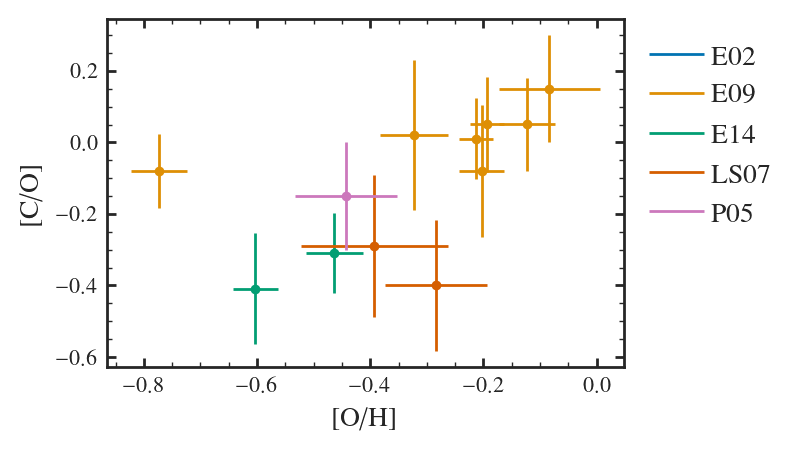

In [56]:
for label in RL.source.unique():
    df = RL.loc[RL.source == label]

    plot_abund_errs(df, label=label)
    
arya.Legend(loc=-1)

## All

In [57]:
RLs = pd.concat([RL, md22, skillman20, tsc16, tsc17])
RL_err = calc_errs(RLs)

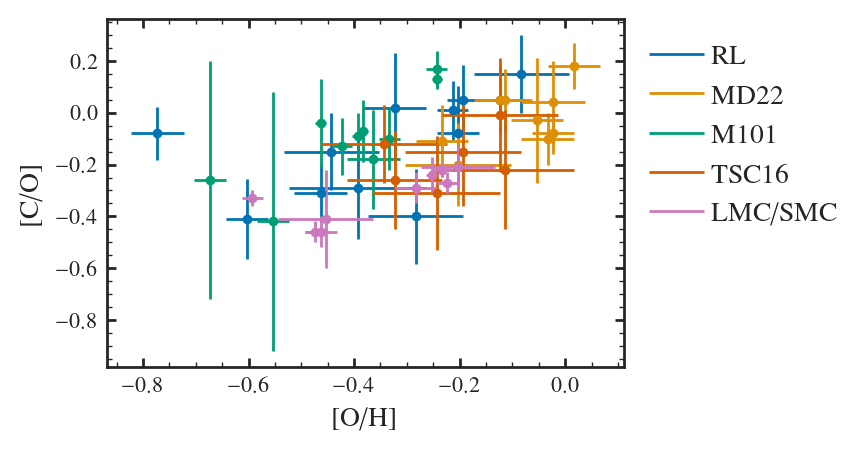

In [58]:
for i in range(5):
    sample = [RL, md22, skillman20, tsc16, tsc17][i]
    label = ["RL", "MD22", "M101", "TSC16", "LMC/SMC"][i]
    plot_abund_errs(sample, label=label)
    
arya.Legend(-1)

## All

In [81]:
RLs = pd.concat([RLs, skillman20, md22, tsc16, tsc17], ignore_index=True)


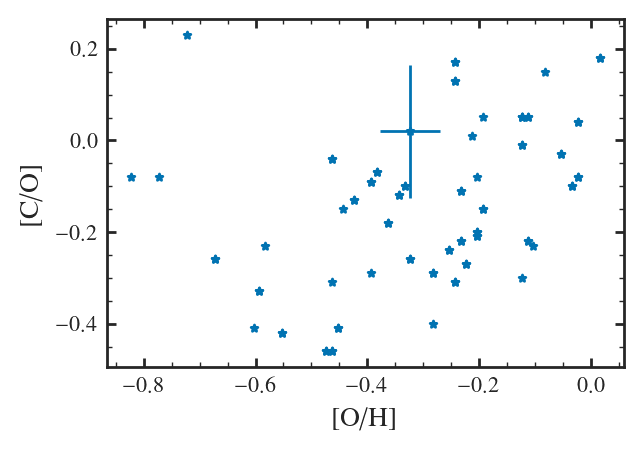

In [60]:
plot_sample_err(RLs, RL_err)

In [63]:
RLs.to_csv("RL_combined.csv")

# Dwarfs (CELs)
- berg 2016, 2019
- Peña-Guerrero et al. 2017 (DUST CORRECTIONS?! also look at GCE discussion)

## Senchyna et al. 2017

## Peña-Guerrero et al. 2017
HST 
- 1909 C III]

10 [O III]  and [O II] lines

In [64]:
pg17 = pd.read_csv(DATA_DIR + "/pena-guerreno+17.csv", sep=r"\s+")


In [65]:
pg17["O_H"] = gcem.eps_to_brak(pg17.eps_o, "o")
pg17["O_H_err"] = pg17.eps_o_err

pg17["C_H"] = gcem.eps_to_brak(pg17.eps_c, "c")
pg17["C_H_err"] = pg17.eps_c_err

pg17["C_O"] = pg17.C_H - pg17.O_H
pg17["C_O_err"] = pg17.C_H_err + pg17.O_H_err

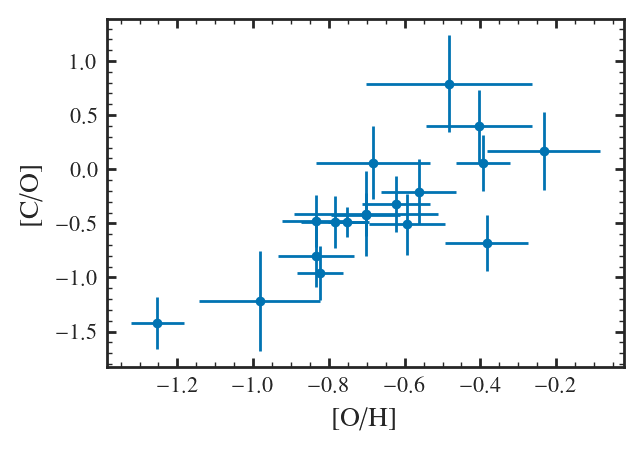

In [66]:
plot_abund_errs(pg17)

## Berg et al. 2019

CEL using UV spectroscopy from HST


In [67]:
berg19_oh = [7.738564437848462, 7.6632886767478245, 7.747268460952228, 7.750820263928443, 7.713715855761903, 7.589795836508764, 7.6974589868035785, 7.645978901768882, 7.6295676065942, 7.544970117524367, 7.612033211664193, 7.583534555372829, 7.72890577995267, 7.697318599334163, 7.712185632345273, 7.868184188359874, 7.91372588343829, 7.910117925474309, 8.026962416268903]
berg19_co = [-0.3746933819064967, -0.48816029143898, -0.5211171827565271, -0.5504310868245295, -0.5995992714025501, -0.6620036429872496, -0.7178384942319369, -0.7848573163327262, -0.8006435944140862, -0.8836429872495446, -0.9455737704918032, -1.038554948391014, -1.0339647844565878, -0.7561748633879781, -0.7804857316332725, -0.655397692774742, -0.5993321190042502, -0.7889981785063751, -0.8897632058287797]

In [68]:
surp.set_yields()

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   3.69e-03 MH^2 + 1.96e-03 MH +  1.45 × cristallo11             0.00e+00                       
                    2.20e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       





In [69]:
berg19 = pd.read_csv(DATA_DIR + "berg19.csv")
berg19 = berg19.iloc[:-1]
berg19["C_O"] = gcem.log_to_brak(berg19.log_c_o, "c", "o")
berg19["O_H"] = gcem.eps_to_brak(berg19.eps_o, "o")
berg19["C_O_err"] = berg19.log_c_o_err
berg19["O_H_err"] = berg19.eps_o_err

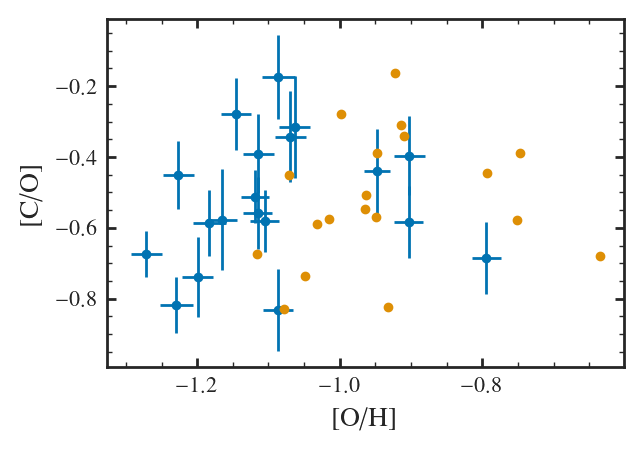

In [70]:
plt.scatter(berg19_oh + eps_o_correction, berg19_co + c_o_correction, color=COLORS[1], zorder=3)
plot_abund_errs(berg19)

## Berg 2016

Carbon lines
- C IV 1548.19 (3)
- C IV 1550.77 (3)
- C III] 1906.68 (all - 1)
- C III 1908.73 (all)
about 8 O lines, and 4 H lines. No Fe.

In [71]:
berg16 = pd.read_csv(DATA_DIR + "berg16.csv")
berg16["C_O"] = gcem.log_to_brak(berg16.log_c_o, "c", "o")
berg16["O_H"] = gcem.eps_to_brak(berg16.eps_o, "o")
berg16["C_O_err"] = berg16.log_c_o_err
berg16["O_H_err"] = berg16.eps_o_err

In [72]:
berg16_eps_o = [7.45492559464121, 7.45492559464121, 7.446516385223216, 7.738760980305644, 7.812141510569171, 7.844879868436886, 7.91093217279692]
berg16_co = [-0.44879174256223436, -0.5934790528233151, -0.6725804493017608, -0.8203400121432909, -0.6636915604128719, -0.6061323618700668, -0.6431086824529447]

In [73]:
berg16_eps_o = [7.3688668986515875, 7.451109177903437, 7.4524684645498045, 7.732209656372336, 7.901859504132231, 7.808971291866029, 7.841028708133972]
berg16_co = [-0.2890780583536705, -0.45288545792930646, -0.7084163112195758, -0.8311306476258066, -0.7682472897913665, -0.6335624126469162, -0.5935121552042524]

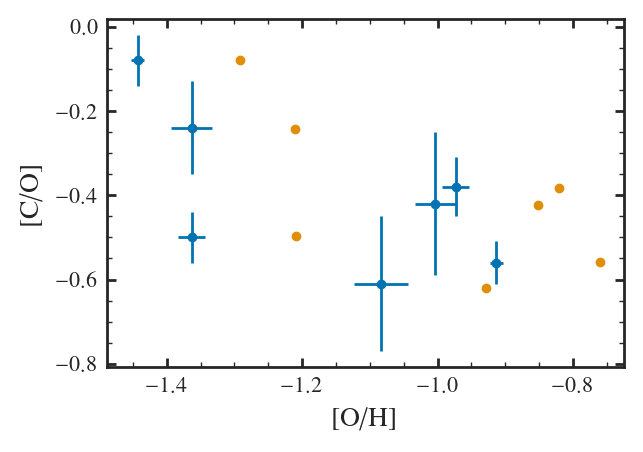

In [74]:
plot_abund_errs(berg16)
plt.scatter(berg16_eps_o + eps_o_correction, berg16_co + c_o_correction, color=COLORS[1], zorder=3)


## All

In [126]:
dwarfs = pd.concat([berg16, berg19, pg17], ignore_index=True)
dwarf_err = calc_errs(dwarfs)

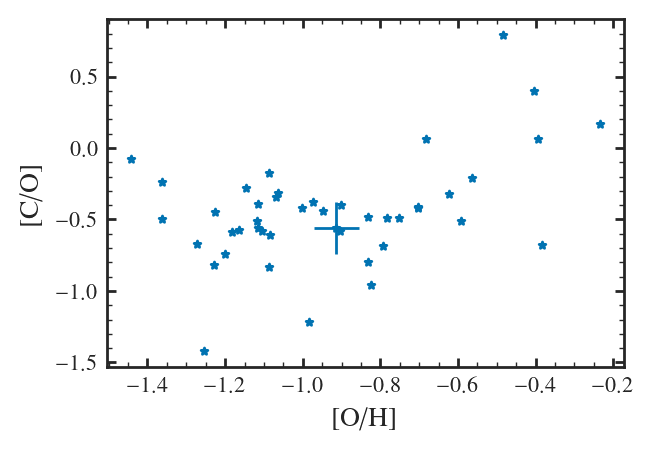

In [128]:
plot_sample_err(dwarfs, dwarf_err)


In [82]:
dwarfs.to_csv("dwarfs_combined.csv")

# DLA
- Mostly as compiled in Cook et al. 2017.
- - 


In [10]:
import toml

In [32]:
with open(DATA_DIR + "DLA.toml", "r") as f:
    dla_raw = toml.load(f)

In [33]:
"log_CII" in dla_raw["cooke+11"].keys()

True

In [34]:
def contains_min_cols(d):
    for col in cols:
        if col not in d.keys():
            print("missing", col)
            return False
    return True

In [36]:
def toml_to_df(y, cols):
    if type(y["galaxy"]) is str:
        series = pd.DataFrame([pd.Series(y)[cols]])
    else:
        ser = {}
        for col in cols:
            ser[col] = y[col]
        print(ser)
        series = pd.DataFrame(ser)
        
    return series

In [15]:
cols = ["galaxy", "redshift"]

In [61]:
cols = ["galaxy", "redshift", "log_HI", "log_HI_err", "log_CII", "log_CII_err", "log_OI", "log_OI_err"]

dla = pd.DataFrame()


for study, attrs in dla_raw.items():
    
    if type(attrs) is dict and contains_min_cols(attrs):
        series = toml_to_df(attrs, cols)
        series["study"] = study
        dla = pd.concat([dla, series], ignore_index=True, axis=0)
    else:
        print("warning, incomplete data for", study)

{'galaxy': ['Q1101-264', 'Q2059-360', 'J2155+1358'], 'redshift': [1.838, 2.507, 4.212], 'log_HI': [19.5, 20.21, 19.61], 'log_HI_err': [0.05, 0.1, 0.1], 'log_CII': [15.06, 14.87, 13.95], 'log_CII_err': [0.07, 0.19, 0.06], 'log_OI': [14.55, 15.54, 14.5], 'log_OI_err': [0.05, 0.21, 0.05]}
missing galaxy
warning, incomplete data for peroux+07
{'galaxy': ['Q0913+072', 'J1016+4040', 'J1558+4053', 'Q2206-199'], 'redshift': [2.618, 2.816, 2.553, 2.076], 'log_HI': [20.34, 19.9, 20.3, 20.43], 'log_HI_err': [0.04, 0.11, 0.04, 0.04], 'log_CII': [13.98, 13.66, 14.22, 14.41], 'log_CII_err': [0.05, 0.04, 0.06, 0.03], 'log_OI': [14.63, 14.13, 14.54, 15.05], 'log_OI_err': [0.01, 0.03, 0.04, 0.03]}
{'galaxy': ['J0311-1722', 'J1001+0343'], 'redshift': [3.734, 3.078], 'log_HI': [20.3, 20.21], 'log_HI_err': [0.06, 0.05], 'log_CII': [14.02, 13.58], 'log_CII_err': [0.08, 0.02], 'log_OI': [14.7, 14.25], 'log_OI_err': [0.08, 0.02]}
missing log_HI
warning, incomplete data for cooke+14
{'galaxy': ['J0035-0918', 

In [62]:
dla["C_O"] = gcem.log_to_brak(dla.log_CII - dla.log_OI, "c", "o")
dla["C_O_err"] = np.sqrt(dla.log_OI_err**2 + dla.log_CII_err**2)

dla["O_H"] = gcem.eps_to_brak(12 + dla.log_OI - dla.log_HI, "o")
dla["O_H_err"] = np.sqrt(dla.log_OI_err**2 + dla.log_HI_err**2)

In [64]:
cooke14 = pd.DataFrame(toml_to_df(dla_raw["cooke+14"], ["galaxy", "C_O", "C_O_err", "O_H", "O_H_err", "redshift"]))

cooke14["study"] = "cooke+14"
dla = pd.concat([dla, cooke14])

{'galaxy': ['HS0105+1619', 'Q0913+072', 'J1358+6522'], 'C_O': [0.11, -0.36, -0.27], 'C_O_err': [0.045, 0.012, 0.06], 'O_H': [-1.776, -2.416, -2.335], 'O_H_err': [0.021, 0.011, 0.02], 'redshift': [2.536, 2.618, 3.067]}


The table is verified. The main difference is cooke does apply the ionization correction to morrison+16; and cooke does not include the first two galaxies in 

In [68]:
def format_with_errors(value, error, precision):
    """
    Format a value and its error with LaTeX formatting and rounding precision.

    Parameters:
    - value (float): The value to format.
    - error (float): The corresponding error.
    - precision (int): The number of decimal places to round to.

    Returns:
    - str: A string formatted with LaTeX math mode including $\pm$.
    """
    return f"${value:.{precision}f} \pm {error:.{precision}f}$"

In [71]:
def dataframe_to_latex_with_errors(df, precisions, caption='', label='', index=False):
    """
    Convert a pandas DataFrame to a LaTeX table, handling columns with errors.

    Parameters:
    - df (pd.DataFrame): The DataFrame to convert.
    - precisions (dict): A dictionary specifying the rounding precision for each column.
    - caption (str): Caption for the table.
    - label (str): Label for referencing the table in LaTeX.
    - index (bool): Whether to include the DataFrame's index in the table.

    Returns:
    - str: A LaTeX tabular environment as a string.
    """
    # Create a copy of the DataFrame to modify
    df_copy = df.copy()

    # Iterate over the columns and format those with companion `_err` columns
    for col in df.columns:
        if col.endswith('_err'):
            main_col = col[:-4]  # Get the corresponding main column name
            if main_col in df.columns:
                precision = precisions.get(main_col, 2)  # Default precision to 2 if not specified
                df_copy[main_col] = df.apply(lambda row: format_with_errors(row[main_col], row[col], precision), axis=1)
                df_copy.drop(columns=[col], inplace=True)  # Drop the `_err` column after formatting

    # Convert the DataFrame to LaTeX
    latex_table = df_copy.to_latex(index=index, escape=False)

    table_env = f"\\begin{{table}}[H]\n\\centering\n{latex_table}"
    
    if caption:
        table_env += f"\\caption{{{caption}}}\n"
    if label:
        table_env += f"\\label{{{label}}}\n"
    
    table_env += "\\end{table}"
    
    return table_env

In [75]:
lt = dataframe_to_latex_with_errors(dla[["galaxy", "redshift", "C_O_err", "C_O", "O_H_err", "O_H", "study"]], precisions={})

print(lt)

\begin{table}[H]
\centering
\begin{tabular}{lrlll}
\toprule
galaxy & redshift & C_O & O_H & study \\
\midrule
Q1101-264 & 1.838000 & $0.77 \pm 0.09$ & $-1.66 \pm 0.07$ & dessauges-zavadsky+03 \\
Q2059-360 & 2.507000 & $-0.41 \pm 0.28$ & $-1.38 \pm 0.23$ & dessauges-zavadsky+03 \\
J2155+1358 & 4.212000 & $-0.29 \pm 0.08$ & $-1.82 \pm 0.11$ & dessauges-zavadsky+03 \\
Q0913+072 & 2.618000 & $-0.39 \pm 0.05$ & $-2.42 \pm 0.04$ & pettini+08 \\
J1016+4040 & 2.816000 & $-0.21 \pm 0.05$ & $-2.48 \pm 0.11$ & pettini+08 \\
J1558+4053 & 2.553000 & $-0.06 \pm 0.07$ & $-2.47 \pm 0.06$ & pettini+08 \\
Q2206-199 & 2.076000 & $-0.38 \pm 0.04$ & $-2.09 \pm 0.05$ & pettini+08 \\
J0140-0839 & 3.696000 & $-0.30 \pm 0.08$ & $-2.77 \pm 0.15$ & ellison+10 \\
J1337+3152 & 3.167000 & $-0.19 \pm 0.11$ & $-2.59 \pm 0.17$ & srianand+10 \\
J0311-1722 & 3.734000 & $-0.42 \pm 0.11$ & $-2.31 \pm 0.10$ & cooke+11 \\
J1001+0343 & 3.078000 & $-0.41 \pm 0.03$ & $-2.67 \pm 0.05$ & cooke+11 \\
J1358+6522 & 3.067295 & $-0.0

In [66]:
dla[["galaxy", "redshift", "C_O", "C_O_err", "O_H", "O_H_err", "study"]]

,galaxy,redshift,C_O,C_O_err,O_H,O_H_err,study
0,Q1101-264,1.838000,0.76995,0.086023,-1.655469,0.070711,dessauges-zavadsky+03
1,Q2059-360,2.507000,-0.41005,0.283196,-1.375469,0.232594,dessauges-zavadsky+03
2,J2155+1358,4.212000,-0.29005,0.078102,-1.815469,0.111803,dessauges-zavadsky+03
3,Q0913+072,2.618000,-0.39005,0.050990,-2.415469,0.041231,pettini+08
4,J1016+4040,2.816000,-0.21005,0.050000,-2.475469,0.114018,pettini+08
5,J1558+4053,2.553000,-0.06005,0.072111,-2.465469,0.056569,pettini+08
6,Q2206-199,2.076000,-0.38005,0.042426,-2.085469,0.050000,pettini+08
7,J0140-0839,3.696000,-0.30005,0.080623,-2.765469,0.150333,ellison+10
8,J1337+3152,3.167000,-0.19005,0.108167,-2.585469,0.174929,srianand+10
9,J0311-1722,3.734000,-0.42005,0.113137,-2.305469,0.100000,cooke+11


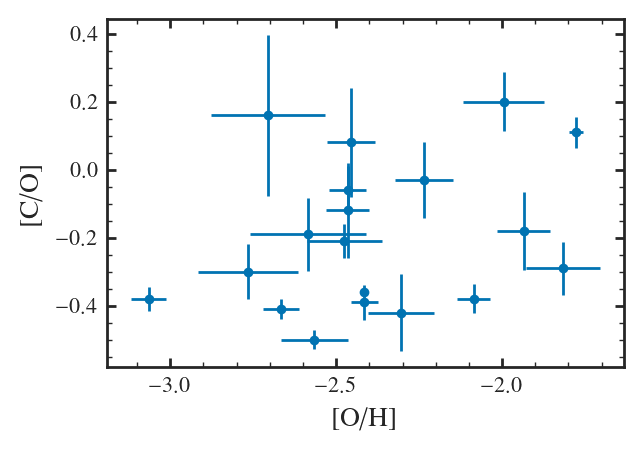

In [59]:
plot_abund_errs(dla[2:-1])

In [77]:
cooke17 = pd.read_csv(DATA_DIR + "cooke17.tsv")

cooke17["C_O"] = cooke17.c_o
cooke17["C_O_err"] = cooke17.c_o_err
cooke17["O_H"] = cooke17.o_h
cooke17["O_H_err"] = cooke17.o_h_err


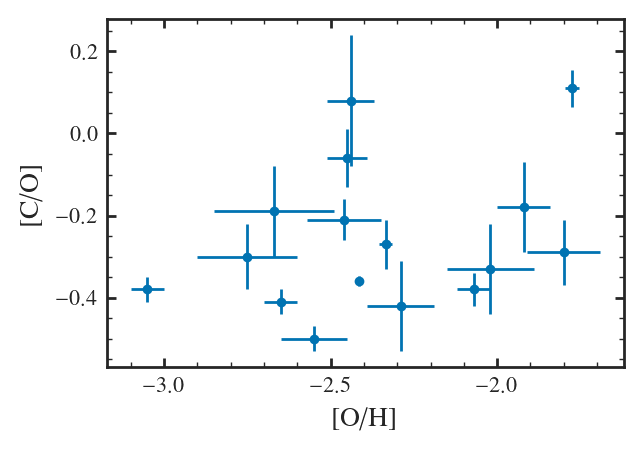

In [78]:
plot_abund_errs(cooke17)

1: Cooke et al. (2015); 2: Dutta et al. (2014); 3: Cooke et al. (2014); 4: Ellison et al. (2010); 5: Cooke et al. (2011b); 6: This work; 7: Pettini et al. (2008); 8: Morrison et al. (2016); 9: Srianand et al. (2010); 10: Cooke et al. (2012); 11: Dessauges-Zavadsky et al. (2003).

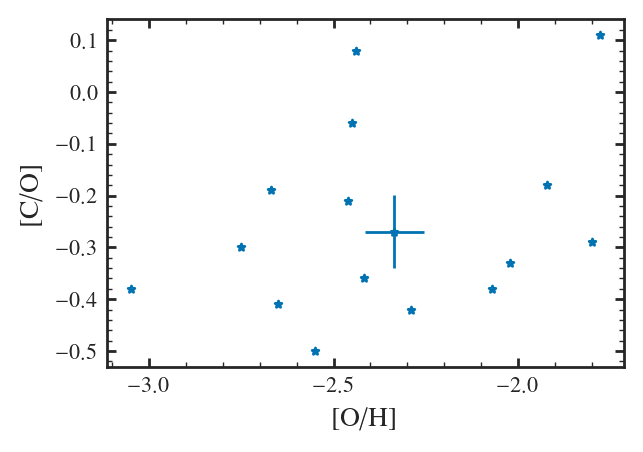

In [79]:
DLA = cooke17
DLA_err = calc_errs(DLA)
plot_sample_err(DLA, DLA_err)

In [80]:
DLA.to_csv("DLA_combined.csv")

# High Z galaxies
High z CEL mentioned in berg and jones

- Pettini et al. 2000
- Fosbury & Villar-Martín et al. 2003
- Fosbury et al. 2003
- Erb et al. 2010
- Christensen et al. 2012
- Bayliss et al. 2014
- James et al. 2014
- Stark et al. 2014
- Steidel et al. 2016
- Vanzella et al. 2016
- Amorín et al. 2017
- Berg et al. 2018
- Rigby et al. 2018
- Mainali et al. 2020
- Matthee et al. 2021
- Rigby et al. 2021
- Iani et al. 2023

JWST results
- AC 2022
- Jones + 2023


### S04590
from Arellano-Córdova et al. 2022 (https://ui.adsabs.harvard.edu/abs/2022ApJ...940L..23A).
lines: 
- C III] 1907
- C III] 1909

### Jones + 2023
similar to above, but for a different galaxy
- C IV 1548.19 
- C IV 1550.77
- C III] 1906.68 
- C III] 1908.73

and two O lines (CEL UV)

Result:
- log(C/O) = -1.01 pm 0.12 (stat) pm 0.15 (sys)
- 12 + log(O/H) = 7.39 pm 0.23

In [85]:
import yaml

In [105]:
with open(DATA_DIR + "high_redshift.yaml", "r") as f:
    high_z_raw = yaml.safe_load(f)

In [106]:
"log_c_o" in high_z_raw["iani+2023"].keys()

True

In [107]:
def contains_min_cols(d):
    for col in cols:
        if col not in d.keys():
            print("missing", col)
            return False
    return True

In [108]:
def yaml_to_df(y):
    if type(y["galaxy"]) is str:
        series = pd.DataFrame([pd.Series(y)[cols]])
    else:
        ser = {}
        for col in cols:
            ser[col] = y[col]
        print(ser)
        series = pd.DataFrame(ser)
        
    return series

In [109]:
yaml_to_df(high_z_raw["christensen+2014"])

{'log_c_o': [-1.03, -0.8], 'eps_o': [7.69, 7.76]}


,log_c_o,eps_o
0,-1.03,7.69
1,-0.80,7.76


In [110]:
cols = ["log_c_o", "galaxy", "redshift", "eps_o", "log_c_o_err", "eps_o_err"]

high_z = pd.DataFrame()


for study, attrs in high_z_raw.items():
    
    if type(attrs) is dict and contains_min_cols(attrs):
        series = yaml_to_df(attrs)
        high_z = pd.concat([high_z, series], ignore_index=True, axis=0)
    else:
        print("warning, incomplete data for", study)

warning, incomplete data for jones+2023
missing log_c_o_err
warning, incomplete data for rigby+2021
missing eps_o_err
warning, incomplete data for berg+2018
missing log_c_o
warning, incomplete data for rigby+2018
warning, incomplete data for perez-montero&amorin2017
missing log_c_o
warning, incomplete data for amorin+2017
missing log_c_o
warning, incomplete data for vanzella+2016
missing log_c_o
warning, incomplete data for bayliss+2014
{'log_c_o': [-1.03, -0.8], 'galaxy': ['A31.1', 'M2031'], 'redshift': [1.8339, 3.5061], 'eps_o': [7.69, 7.76], 'log_c_o_err': [0.08, 0.09], 'eps_o_err': [0.13, 0.03]}
warning, incomplete data for conroy+2014
missing log_c_o
warning, incomplete data for james+2014
missing log_c_o
warning, incomplete data for stark+2014
warning, incomplete data for leitherer2011
warning, incomplete data for leitherer+2011
missing log_c_o
warning, incomplete data for fosbury+2003
warning, incomplete data for fosbury+2003b
missing log_c_o
warning, incomplete data for pettini

/tmp/ipykernel_3862843/1387110311.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  high_z = pd.concat([high_z, series], ignore_index=True, axis=0)


In [111]:
high_z

,log_c_o,galaxy,redshift,eps_o,log_c_o_err,eps_o_err
0,-0.99,abell2895b,3.72096,7.36,0.23,0.02
1,-0.80,none,NaN,8.21,0.20,0.03
2,-0.68,RXCJ0232−588,1.64480,7.60,0.19,0.24
3,-0.60,stack,2.40000,8.38,0.09,0.10
4,-1.03,A31.1,1.83390,7.69,0.08,0.13
5,-0.80,M2031,3.50610,7.76,0.09,0.03
6,-0.62,"Q2343-BX418,",2.30480,7.80,0.10,0.10


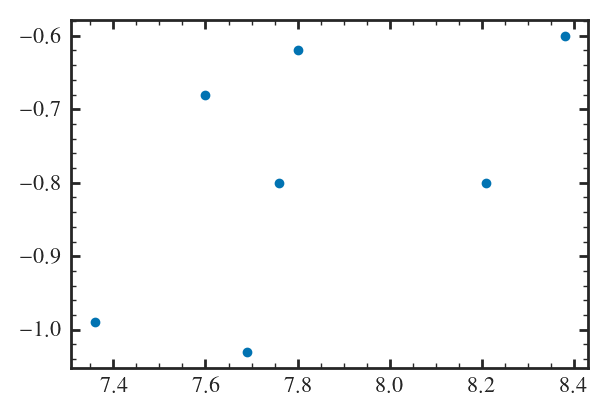

In [112]:
plt.scatter(high_z.eps_o, high_z.log_c_o)

In [113]:
high_z["O_H"] = gcem.eps_to_brak(high_z.eps_o, "o")
high_z["C_O"] = gcem.log_to_brak(high_z.log_c_o, "c", "o")
high_z["O_H_err"] = high_z.eps_o_err
high_z["C_O_err"] = high_z.log_c_o_err

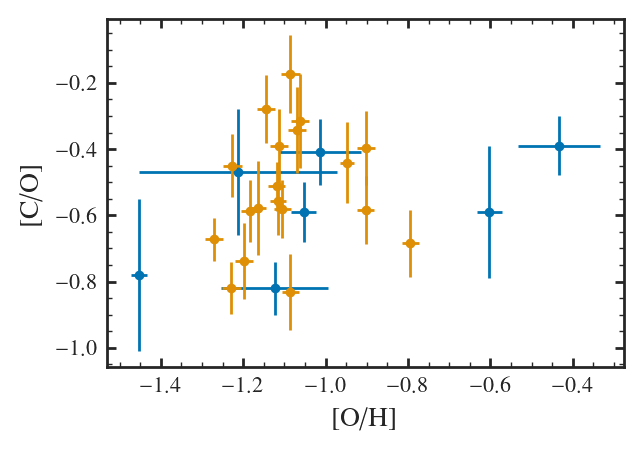

In [114]:
plot_abund_errs(high_z)
plot_abund_errs(berg19)

In [116]:
high_z.to_csv("high_z_cleaned.csv")